### LIBRARIES USED

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from matplotlib import colors
from IPython import display
import time
from scipy.signal import convolve2d
import os

import functionsAndClasses as fc

### City Model

The city is represented as a L x L grid, in which there is two kinds of agents, residents and merchants. The residents wants to be in a no so dense region of the city and the merchants want to be in a high density region.

### Cluser stability analysis

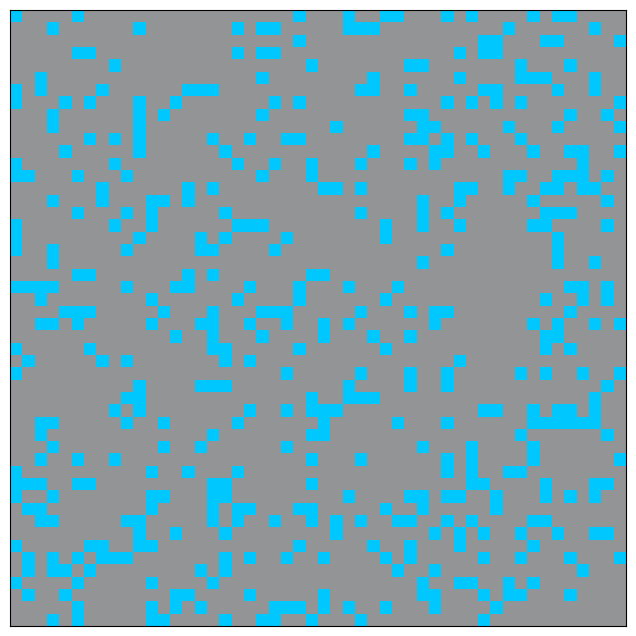

In [72]:
L = 50
agentDensity = 0.2
minimalNumberOfNeighbors = 8
residentRelativeDensity = 0
timeSteps = 10000
periodicBoundaries = False
unitaryEvolution = False
plot = True
args = [('neighborhood', 1), ('minimal_neighbors_merchant_density', minimalNumberOfNeighbors/8), ('minimal_merchant_neighbors_resident_density', 0)]

city = fc.City(L, agentDensity, residentRelativeDensity)
city.change_properties(args)

if unitaryEvolution:
    for i in range(timeSteps * 1000):
        city.evolve_unitary(periodicBoundaries, 1)
    
        if i%50 == 0 and plot:
            city.print_city()
            display.clear_output(wait=True)

    display.clear_output(wait=True)
    city.print_city()


else:
    for i in range(timeSteps):
        # stop condition
        if i%5 == 0:
            oldCity = np.copy(city.city)
            city.evolve(periodicBoundaries, 1)
            dif = oldCity - city.city
            if all(all(element == 0) for element in dif):
                city.print_city()
                break

        else:
            city.evolve(periodicBoundaries, 1)

        if i%100 == 0 and plot:
            city.print_city()
            display.clear_output(wait=True)

    display.clear_output(wait=True)
    city.print_city()

### Clustering analysis for multiple cases

In [73]:
L = 50
residentRelativeDensity = 0
timeSteps = 10000
periodicBoundaries = False
unitaryEvolution = False
plot = False
simulations = 100

agentDensityArray = [0.2, 0.5, 0.8]
numbers = np.arange(0,9)

numClustersAverageDict = dict()
maxClusterSizeAverageDict = dict()

for agentDensity in agentDensityArray:
    for number in numbers:
        numClustersArray = np.zeros(simulations)
        maxClusterSizeAverageArray = np.zeros(simulations)
    
        minimal_neighbors_merchant_density = number/8
        args = [('neighborhood', 1), ('minimal_neighbors_merchant_density', minimal_neighbors_merchant_density), ('minimal_merchant_neighbors_resident_density', 0)]
        
        for i in range(simulations):
            city = fc.City(L, agentDensity, residentRelativeDensity)
            city.change_properties(args)
            
            if unitaryEvolution:
                for k in range(timeSteps * 1000):
                    city.evolve_unitary(periodicBoundaries, 1)
                
                    if k%50 == 0 and plot:
                        city.print_city()
                        display.clear_output(wait=True)
        
                if plot:
                    display.clear_output(wait=True)
                    city.print_city()
            
            
            else:
                for k in range(timeSteps):
                    # stop condition
                    if k%5 == 0:
                        oldCity = np.copy(city.city)
                        city.evolve(periodicBoundaries, 1)
                        dif = oldCity - city.city
                        if all(all(element == 0) for element in dif):
                            if plot:
                                city.print_city()
                            break
            
                    else:
                        city.evolve(periodicBoundaries, 1)
            
                    if k%200 == 0 and plot:
                        city.print_city()
                        display.clear_output(wait=True)
        
                if plot:
                    display.clear_output(wait=True)
                    city.print_city()
        
            HK_class = fc.HoshenKopelman(city.city)
            labels = HK_class.hk(city.merchant_value, periodicBoundaries)
            numClusters, clustersSizes, clustersSizesAverageAcquired = HK_class.cluster_data()
            numClustersArray[i] = numClusters    
            maxClusterSizeAverageArray[i] = max(list(clustersSizes.values()))/(L*L*agentDensity*(1-residentRelativeDensity))
    
        numClustersAverage = float(numClustersArray.sum())/simulations
        maxClusterSizeAverage = float(maxClusterSizeAverageArray.sum())/simulations
        
        numClustersAverageDict[(np.round(agentDensity,3),number)] = np.round(numClustersAverage,1)
        maxClusterSizeAverageDict[(np.round(agentDensity,3),number)] = np.round(maxClusterSizeAverage,3)

In [74]:
#print(numClustersAverageDict)
#print()
#print(maxClusterSizeAverageDict)

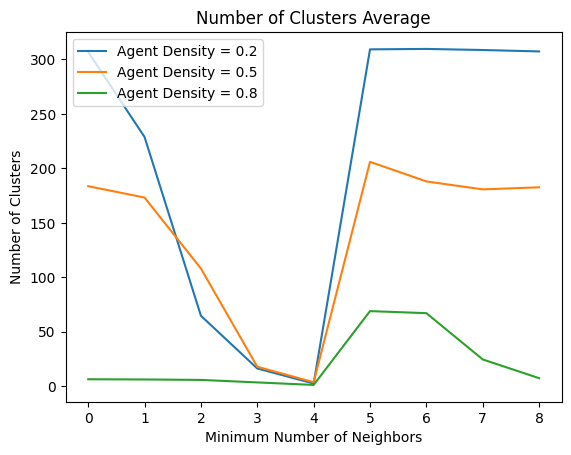

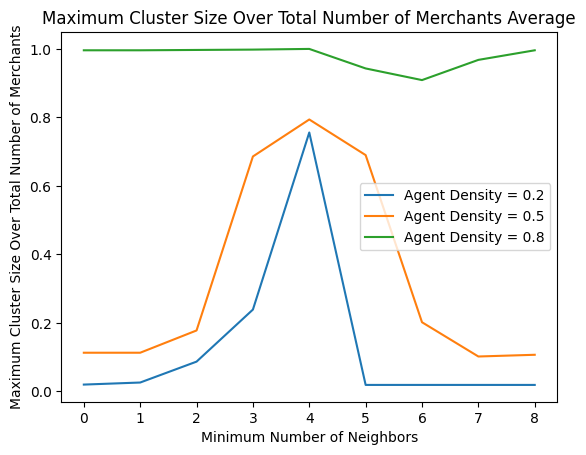

In [76]:
datas = [numClustersAverageDict, maxClusterSizeAverageDict]
numbers = np.arange(0,9)

for i in range(len(datas)):
    data = datas[i]
    values = list(data.values())

    plt.figure()
    aux = 0
    for j in range(len(agentDensityArray)):
        ys = values[aux:aux+len(numbers)]
        aux += len(numbers)

        if i == 0:
            plt.title('Number of Clusters Average')
            plt.ylabel('Number of Clusters')
        elif i == 1:
            plt.title('Maximum Cluster Size Over Total Number of Merchants Average')
            plt.ylabel('Maximum Cluster Size Over Total Number of Merchants')
    
        plt.xlabel('Minimum Number of Neighbors')
        plt.plot(numbers, ys, label = 'Agent Density = ' + str(agentDensityArray[j]))
        plt.legend()
    plt.show()

### Heatmaps

In [23]:
def generate_heatmap(data,title):
    # Extrair chaves e valores do dicionário
    keys = list(data.keys())
    values = list(data.values())

    # Obter valores únicos de agentDensity e residentRelativeDensity
    agent_density_values = np.unique([key[0] for key in keys])
    relative_density_values = np.unique([key[1] for key in keys])

    # Criar matriz de zeros para armazenar os valores do heatmap
    heatmap_data = np.zeros((len(relative_density_values), len(agent_density_values)))

    # Preencher a matriz com os valores do dicionário
    for i, agent_density in enumerate(agent_density_values):
        for j, relative_density in enumerate(relative_density_values):
            key = (agent_density, relative_density)
            if key in data:
                heatmap_data[j, i] = data[key]

    # Criar o heatmap
    plt.imshow(heatmap_data, cmap='viridis', extent=[0, 1,
                                                    0, 9], aspect = 'auto',
               origin='lower', vmin=min(values), vmax=max(values))
    plt.colorbar(label=title)
    plt.xlabel('Agent Density')
    plt.ylabel('Minimal neighbors merchant density')
    plt.title(title + ' Heatmap')
    plt.show()

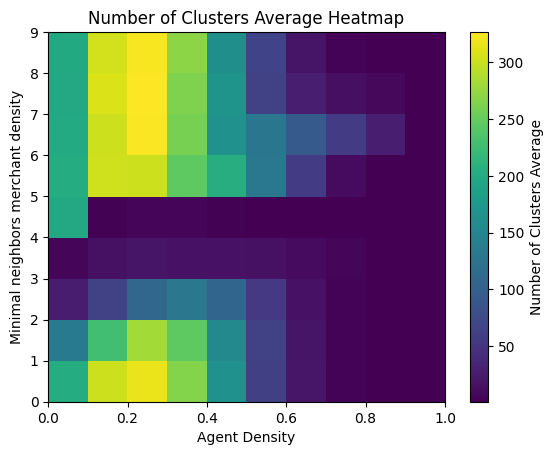

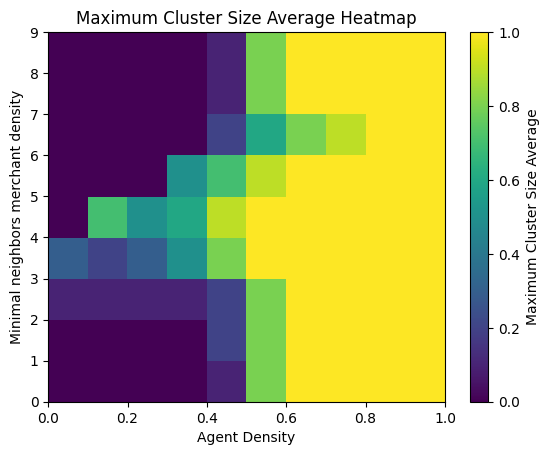

In [24]:
#print(numClustersAverageDict)
generate_heatmap(numClustersAverageDict, 'Number of Clusters Average')

generate_heatmap(maxClusterSizeAverageDict, 'Maximum Cluster Size Average')

### Clustering stability for a pre-existing cluster

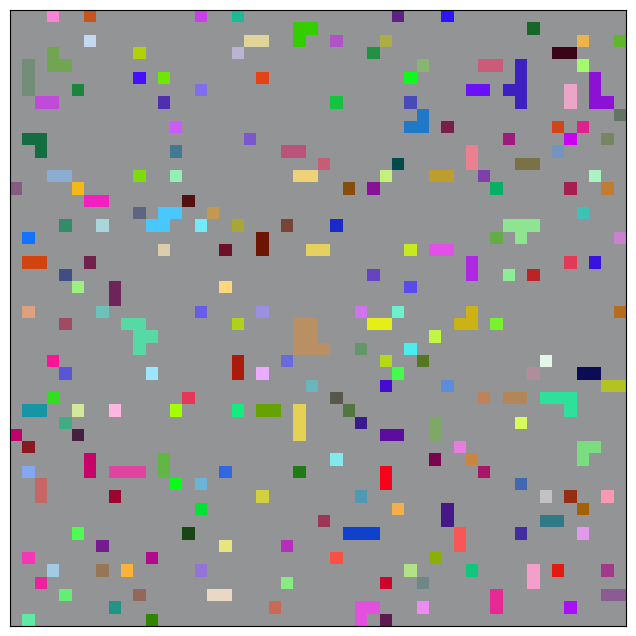

0.4 12.6 7


In [20]:
L = 50
matrix = np.zeros((L,L), dtype = np.int8)
core_shape = 'circle'
core_side = 20
timeSteps = 10000
minimal_neighbors_merchant_density = 5/8
periodicBoundaries = False
unitaryEvolution = True
plot = True

initialSize = 0
if core_shape == 'circle':
    a = (L - core_side)//2
    for i in range(a, a+core_side):
        for j in range(a, a+core_side):
            if (i - (a+core_side/2))**2 + (j - (a+core_side/2))**2 <= (core_side/2)**2:
                matrix[i][j] = fc.City.merchant_value
                initialSize += 1

    
if core_shape == 'square':
    a = (L - core_side)//2
    for i in range(a, a+core_side):
        for j in range(a, a+core_side):
            matrix[i][j] = fc.City.merchant_value
            initialSize += 1
    
city = fc.City(matrix)

if unitaryEvolution:
    for i in range(timeSteps):
        city.evolve_unitary(periodicBoundaries, 1)
    
        if i%500 == 0 and plot:
            city.print_city()
            display.clear_output(wait=True)

else:
    for i in range(timeSteps):
        city.evolve(periodicBoundaries, 1)

        if i%5 == 0 and plot:
            city.print_city()
            display.clear_output(wait=True)

HK_class = fc.HoshenKopelman(city.city)
labels = HK_class.hk(city.merchant_value, periodicBoundaries)
numClusters, clustersSizes, clustersSizesAverage = HK_class.cluster_data()



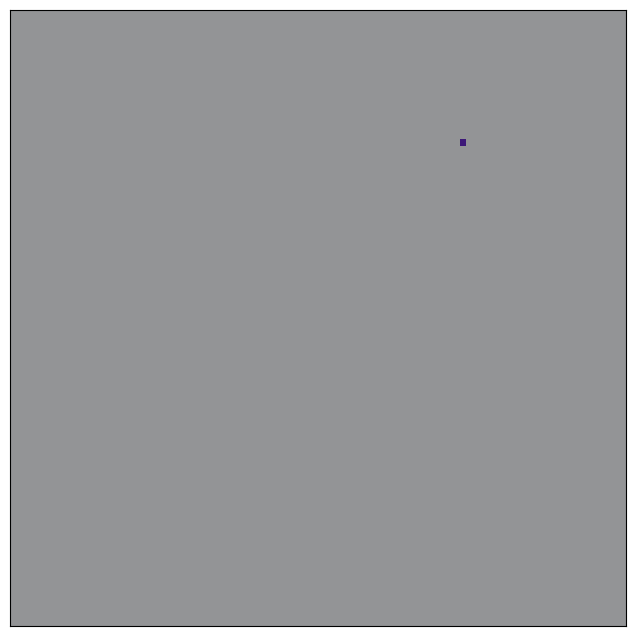

0.01 0.0 1


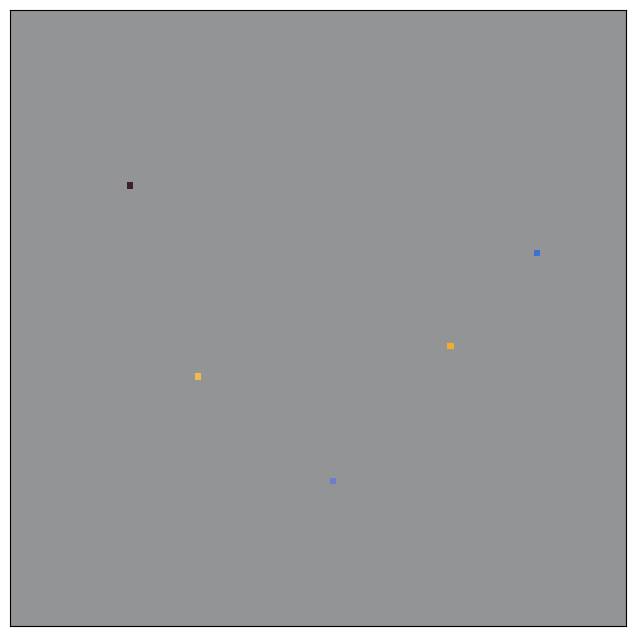

0.02 0.0 1


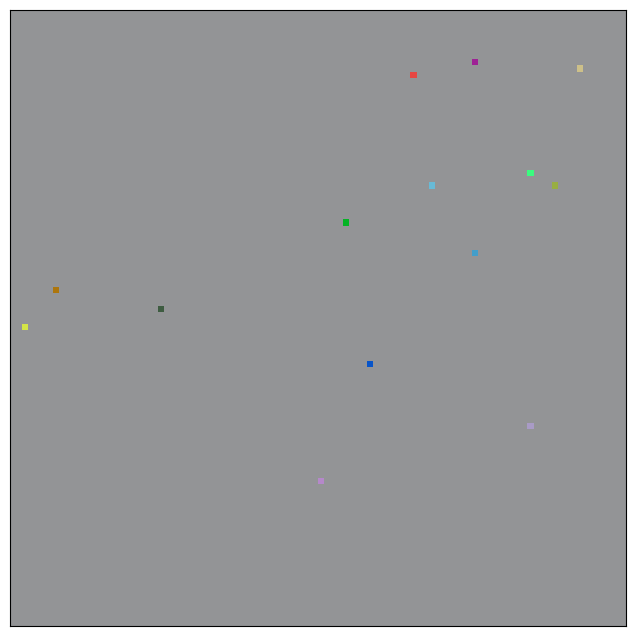

0.03 0.1 1


KeyboardInterrupt: 

In [6]:
L = 100
matrix = np.zeros((L,L), dtype = np.int8)
core_shape = 'square'
core_sideArray = np.arange(1, 50)
periodicBoundaries = True
timeSteps = 10000

for core_side in core_sideArray:
    # creates merchant core
    if core_shape == 'circle':
        a = (L - core_side)//2
        for i in range(a, a+side):
            for j in range(a, a+side):
                if (i - (a+side/2))**2 + (j - (a+side/2))**2 <= (core_side/2)**2:
                    matrix[i][j] = fc.City.merchant_value
    
        
    if core_shape == 'square':
        a = (L - core_side)//2
        for i in range(a, a+core_side):
            for j in range(a, a+core_side):
                matrix[i][j] = fc.City.merchant_value
    
    city = fc.City(matrix)
    city.evolve(periodicBoundaries, timeSteps)
    
    HK_class = fc.HoshenKopelman(city.city)
    labels = HK_class.hk(city.merchant_value, periodicBoundaries)
    numClusters, clustersSizes, clustersSizesAverage = HK_class.cluster_data()
    fc.plot_generic_grid(labels)
    print(float(core_side)/L, np.round(100*(1 - float(len(city.vacantArray))/(L*L)),1), np.max(list(clustersSizes.values())))